In [2]:
import os
from typing import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors

In [3]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=64, dim=128, 
                 normalize_input=True, vladv2=False, use_faiss=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
            vladv2 : bool
                If true, use vladv2 otherwise use vladv1
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = 0
        self.vladv2 = vladv2
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=vladv2)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self.use_faiss = use_faiss

    def init_params(self, clsts: np.ndarray, traindescs: np.ndarray):
        """
        Args:
            clsts: cluster centers
            traindescs: train descriptors
        """
        if not self.vladv2:
            clstsAssign = clsts / np.linalg.norm(clsts, axis=1, keepdims=True)
            dots = np.dot(clstsAssign, traindescs.T)
            dots.sort(axis=0)
            dots = dots[::-1, :] # sort, descending

            self.alpha = (-np.log(0.01) / np.mean(dots[0,:] - dots[1,:])).item()
            self.centroids = nn.Parameter(torch.from_numpy(clsts))
            self.conv.weight = nn.Parameter(torch.from_numpy(self.alpha*clstsAssign).unsqueeze(2).unsqueeze(3))
            self.conv.bias = None
        else:
            if not self.use_faiss:
                knn = NearestNeighbors(n_jobs=-1)
                knn.fit(traindescs)
                del traindescs
                ds_sq = np.square(knn.kneighbors(clsts, 2)[1])
                del knn
            else:
                index = faiss.IndexFlatL2(traindescs.shape[1])
                # noinspection PyArgumentList
                index.add(traindescs)
                del traindescs
                # noinspection PyArgumentList
                ds_sq = np.square(index.search(clsts, 2)[1])
                del index
                
            self.alpha = (-np.log(0.01) / np.mean(ds_sq[:,1] - ds_sq[:,0])).item()
            self.centroids = nn.Parameter(torch.from_numpy(clsts))
            del clsts, ds_sq

            self.conv.weight = nn.Parameter(
                (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
            )
            self.conv.bias = nn.Parameter(
                - self.alpha * self.centroids.norm(dim=1)
            )

    def forward(self, x):
        # print(f"shape of x = {x.shape}")
        N, C = x.shape[:2] # N: batch_size, C: channels=512 for vgg16 as encoder

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        vlad = torch.zeros([N, self.num_clusters, C], dtype=x.dtype, layout=x.layout, device=x.device)
        for C in range(self.num_clusters): # slower than non-looped, but lower memory usage 
            # residual: (N, num_clusters, C, H * W)
            residual = x_flatten.unsqueeze(0).permute(1, 0, 2, 3) - \
                    self.centroids[C:C+1, :].expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
            residual *= soft_assign[:, C:C+1, :].unsqueeze(2)
            vlad[:, C:C+1, :] = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad


class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, input):
        return F.normalize(input, p=2, dim=self.dim)

In [57]:
# create model, contains an encoder and a pooling layer
pool = NetVLAD(num_clusters=64, dim=512)

vgg16_model = models.vgg16()
# capture only feature part and remove last relu and maxpool
layers = list(vgg16_model.features.children())[:-2]
encoder = nn.Sequential(*layers)

model = nn.Module()
model.add_module("encoder", encoder)
model.add_module("pool", netvlad_model)
model.eval()

print(model.state_dict().keys())

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.5.weight', 'encoder.5.bias', 'encoder.7.weight', 'encoder.7.bias', 'encoder.10.weight', 'encoder.10.bias', 'encoder.12.weight', 'encoder.12.bias', 'encoder.14.weight', 'encoder.14.bias', 'encoder.17.weight', 'encoder.17.bias', 'encoder.19.weight', 'encoder.19.bias', 'encoder.21.weight', 'encoder.21.bias', 'encoder.24.weight', 'encoder.24.bias', 'encoder.26.weight', 'encoder.26.bias', 'encoder.28.weight', 'encoder.28.bias', 'pool.centroids', 'pool.conv.weight'])


In [59]:
# load checkpoint from local
netvlad_checkpoint_path = "../vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar"
netvlad_checkpoint = torch.load(netvlad_checkpoint_path,  map_location=torch.device('cpu'))
print(netvlad_checkpoint['state_dict'].keys())

# update state_dict using checkpoint
model.load_state_dict(netvlad_checkpoint['state_dict'])

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.5.weight', 'encoder.5.bias', 'encoder.7.weight', 'encoder.7.bias', 'encoder.10.weight', 'encoder.10.bias', 'encoder.12.weight', 'encoder.12.bias', 'encoder.14.weight', 'encoder.14.bias', 'encoder.17.weight', 'encoder.17.bias', 'encoder.19.weight', 'encoder.19.bias', 'encoder.21.weight', 'encoder.21.bias', 'encoder.24.weight', 'encoder.24.bias', 'encoder.26.weight', 'encoder.26.bias', 'encoder.28.weight', 'encoder.28.bias', 'pool.centroids', 'pool.conv.weight'])


<All keys matched successfully>

In [60]:
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 将 BGR 转为 RGB
        if self.transform:
            image = self.transform(image)
        return image

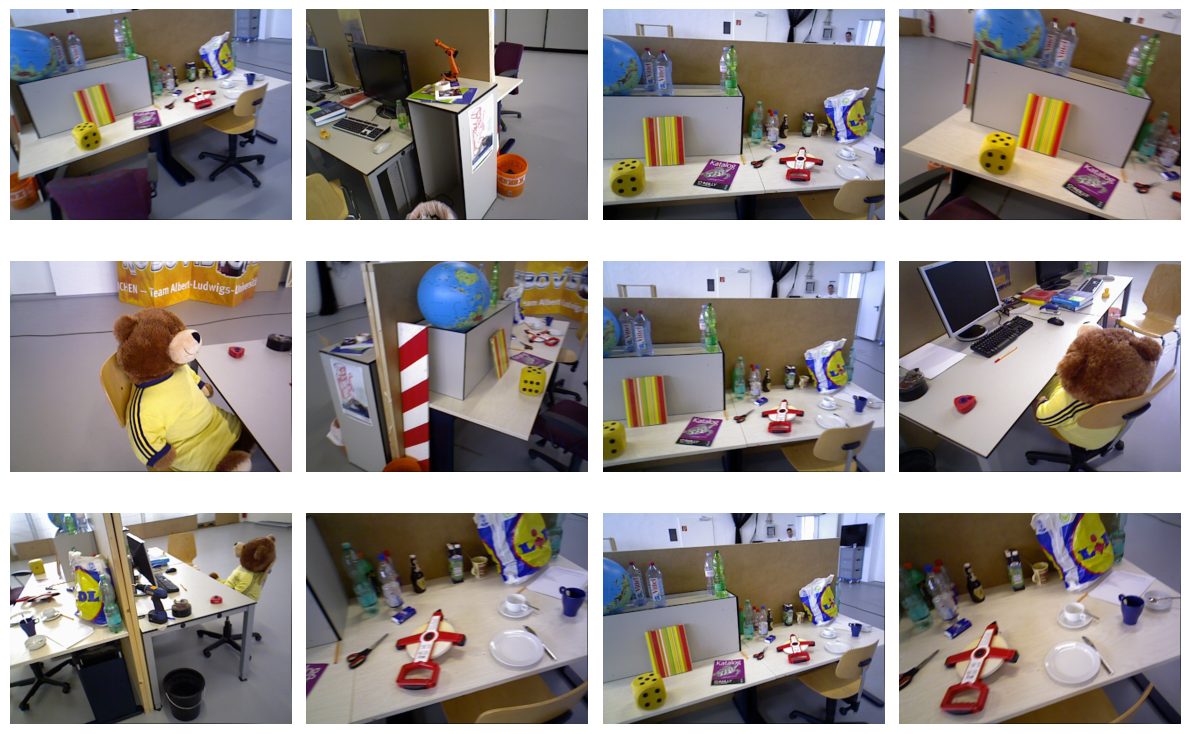

In [61]:
dataset_path = "/Users/xuhuili/Documents/SA/datasets/tum_rgbd/rgbd_dataset_freiburg3_long_office_household/rgb"
transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor()
])

dataset = ImageDataset(dataset_path, transform)
#dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
#data_iter = iter(dataloader)
#image_tensor = next(data_iter)

images= []
for i in range(2400):
    if i % 200 == 0:
        image = dataset[i]
        images.append(image)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
axes = axes.flatten()
for img_tensor, ax in zip(images, axes):
    img_np = img_tensor.numpy().transpose((1, 2, 0))
    img_np = np.clip(img_np, 0, 1)

    ax.imshow(img_np)
    ax.axis('off') 

plt.tight_layout()
plt.show()

In [62]:
# get descriptors for each image
descriptors = []
for image in images:
    encoder_vec = model.encoder(image.unsqueeze(0))
    netvlad_vec = model.pool(encoder_vec)
    descriptors.append(netvlad_vec)


The query image1046 is closest to image_7


(-0.5, 639.5, 479.5, -0.5)

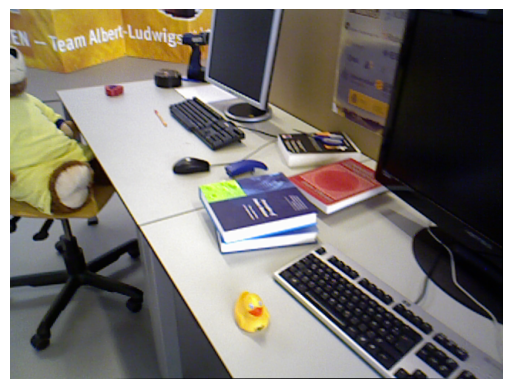

In [84]:
query_idx = np.random.randint(0, 2400)
query_image = dataset[query_idx]
encoder_query = model.encoder(query_image.unsqueeze(0))
netvlad_query = model.pool(encoder_query)

res_max = 0
idx_closest = 0
for idx, descriptor in enumerate(descriptors):
    res = descriptor @ netvlad_query.T.squeeze()
    if res.data > res_max:
        res_max = res
        idx_closest = idx

print(f"The query image_{query_idx} is closest to image_{idx_closest} in database")

# display query image
query_img_np = query_image.numpy().transpose((1, 2, 0))
query_img_np = np.clip(query_img_np, 0, 1)
plt.imshow(query_img_np)
plt.axis('off') 

In [ ]:
# TODO: store the vlad features of keyframes in a kd tree, KNN search with faiss
